In [ ]:
# !pip install opencv-python

In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import random
from PIL import Image
from IPython.display import display

In [2]:
train = pd.read_csv("../data/csv/train_diagramas.csv")
val = pd.read_csv("../data/csv/val_diagramas.csv")
test = pd.read_csv("../data/csv/test_diagramas.csv")

In [3]:
IMG_PATH = "../data/imagenes_diagramas/ERDiagramsMySQL-14.png"

## First test

In [213]:
def poly_detection(img_path):

    inputImage = cv2.imread(img_path)
    inputImageGray = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(inputImageGray, 150, 200, apertureSize = 3)
    minLineLength = 100
    maxLineGap = 1

    lines = cv2.HoughLinesP(edges,cv2.HOUGH_PROBABILISTIC, np.pi/180, 10, minLineLength, maxLineGap)
    
    return lines, inputImage

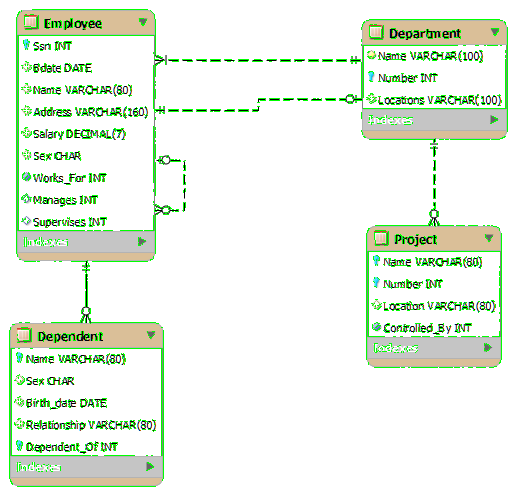

In [214]:
lines, img1 = poly_detection(IMG_PATH)
for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
        pts = np.array([[x1, y1 ], [x2 , y2]], np.int32)
        cv2.polylines(img1, [pts], True, (0,255,0))
        
Image.fromarray(img1)

## Try removing the lines for the tables and/or attributes

In [209]:
def get_tables_from_image(img_path):
    img_path = img_path[3:]
    path = "C:/Users/Diego/Desktop/TFI-Cazcarra/" + img_path
    path = path.replace("/","\\")
    if path in train['image_path'].values:
        return train[(train['image_path']==path) & (train['label']=="tabla")].copy()
    elif path in test['image_path'].values:
        return test[(test['image_path']==path) & (test['label']=="tabla")].copy()
    else:
        return val[(val['image_path']==path) & (val['label']=="tabla")].copy()

In [215]:
def line_inside_tables(line, tables, offset=15):
    tables['arr'] = tables.apply(lambda x: (x['xmin'], x['ymin'], x['xmax'], x['ymax']) , axis=1)
    for table in tables['arr'].values:
        xmin_condition = line[0] >= table[0]-offset
        ymin_condition = line[1] >= table[1]-offset
        xmax_condition = line[2] <= table[2]+offset
        ymax_condition = line[3] <= table[3]+offset
        
        if xmin_condition and xmax_condition and ymin_condition and ymax_condition:
            return True
    return False

def nearest_neighbour(p, points):
    dist_dict = {q: math.dist(p, q) for q in points}
    return min(dist_dict, key=dist_dict.get), min(dist_dict.values())

In [216]:
lines, img2 = poly_detection(IMG_PATH)
tables = get_tables_from_image(IMG_PATH)

all_points = []
#Hay casos donde la linea entera detectada esta un poquito adentro del offset. Hay que corregir eso
for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
        if not line_inside_tables(line=(x1,y1,x2,y2), tables=tables):
            pts = np.array([[x1, y1 ], [x2 , y2]], np.int32)
            cv2.polylines(img2, [pts], True, (255,0,0))
            all_points.append((x1,y1))
            all_points.append((x2,y2))
#         else:
#             pts = np.array([[x1, y1 ], [x2 , y2]], np.int32)
#             cv2.polylines(img2, [pts], True, (0,0,255))
# Image.fromarray(img2)

170 161 185 160
346 59 346 61
185 191 172 211
168 109 345 98
257 111 257 111
435 180 433 146
87 278 85 291
168 59 238 59
244 61 280 59
432 209 435 208


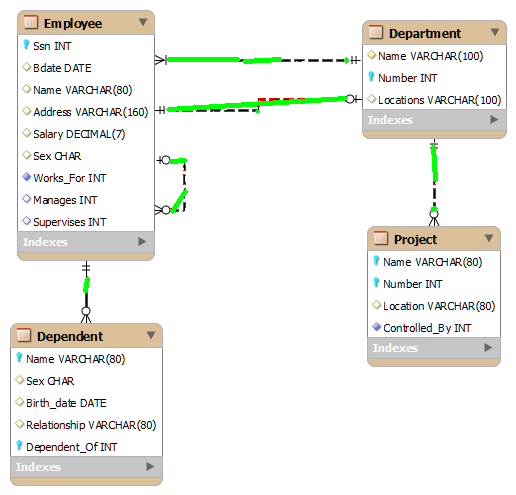

In [217]:
aux_points = all_points

try:
    for i in range(10):
        LINE = random.sample(aux_points, k=1)
        aux_points.remove(LINE[0])
        flagged = True
        while flagged and aux_points:
            nearest_point, dist = nearest_neighbour(LINE[-1], aux_points)
            if dist < 25:
                start_before = (LINE[0][0], LINE[-1][0])
                end_before = (LINE[-1][0], LINE[-1][1])
                dist_before = math.dist(start_before, end_before)

                LINE.append(nearest_point)
                aux_points.remove(nearest_point)

                start_after = (LINE[0][0], LINE[-1][0])
                end_after = (LINE[-1][0], LINE[-1][1])
                dist_after = math.dist(start_after, end_after)

                if dist_before >= dist_after:
                    LINE.remove(nearest_point)
            nearest_point_2, dist_2 = nearest_neighbour(LINE[0], aux_points)
            if dist_2 < 25:
                start_before = (LINE[0][0], LINE[-1][0])
                end_before = (LINE[-1][0], LINE[-1][1])
                dist_before = math.dist(start_before, end_before)

                LINE.insert(0, nearest_point_2)
                aux_points.remove(nearest_point_2)

                start_after = (LINE[0][0], LINE[-1][0])
                end_after = (LINE[-1][0], LINE[-1][1])
                dist_after = math.dist(start_after, end_after)

                if dist_before >= dist_after:
                    LINE.remove(nearest_point_2)
            else:
                np_x1, np_y1, np_x2, np_y2 = LINE[0][0], LINE[0][1], LINE[-1][0], LINE[-1][1]
                last_point = np.array([[np_x1, np_y1], [np_x2 , np_y2]], np.int32)
                cv2.polylines(img2, [last_point], True, (0,255,0), thickness=3) 
                flagged = False
                print(np_x1, np_y1, np_x2, np_y2)
except Exception as e:
    pass
finally:
    display(Image.fromarray(img2))